# Plotting Images 

##### New Kernel

In [2]:
import sys
sys.path += ["../include/", "../"]
from images import *
import scipy.constants as sc

##### Load the data

In [3]:
x_group3, y_group3, i_group3, s_group3 = group_3(False)
x_num4, y_num4, i_num4, s_num4 = num_4(False)
x_bar, y_bar, i_bar, s_bar = smallest_bar(False)

ind_inbw_patt = [57, 35]
ind_inbw_bar = [30, 27]
ind_on_bar = [24, 19]

frep = 1e9
ppifg = 74180
center = ppifg // 2
Nyq_freq = frep * center
nu = np.linspace(0, Nyq_freq, center) + Nyq_freq * 2
wl = sc.c / nu * 1e6


In [4]:
wl_ll, wl_ul = 3.25, 3.6
ind_ll, ind_ul = np.argmin(abs(wl - wl_ul)), np.argmin(abs(wl - wl_ll))

abs_group3 = s_group3 / s_group3[0, 0]
abs_group3 = - np.log(abs_group3)
i_group3 = simps(abs_group3[:, :, ind_ll:ind_ul], axis=-1)
i_group3 -= i_group3.min()
i_group3 *= -1

abs_bar = s_bar / s_bar[0, 0]
abs_bar = - np.log(abs_bar)
i_bar = simps(abs_bar[:, :, ind_ll:ind_ul], axis=-1)
i_bar -= i_bar.min()
i_bar *= -1

abs_num4 = s_num4 / s_num4[0, 0]
abs_num4 = - np.log(abs_num4)
i_num4 = simps(abs_num4[:, :, ind_ll:ind_ul], axis=-1)
i_num4 -= i_num4.min()
i_num4 *= -1


In [6]:
cmap = 'cividis'


##### The plots below show the images taken on the smallest group that's on the airforce target. I imaged the smallest group at coarse 10 $\mu m$ resolution, and then did a finer below diffraction limit image of the smallest pattern that's on the silicon wafer. 

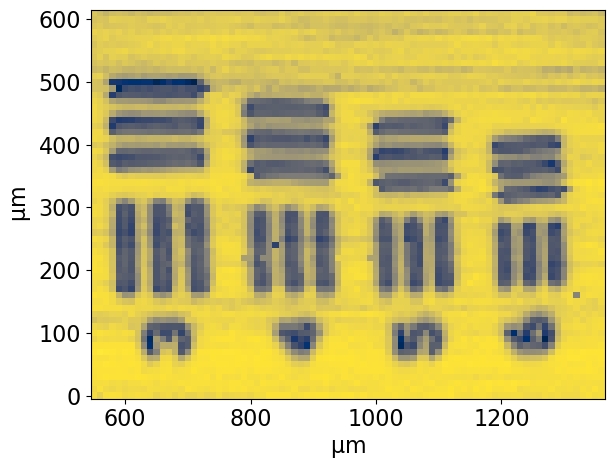

In [7]:
# group 3
x_group3_ = x_group3 - x_group3.min()
ind = np.argmin(abs(x_group3_ - 550))
fig, ax = plt.subplots(1, 1, dpi=100)
ax.pcolormesh(x_group3_[ind:], y_group3 - y_group3.min(), i_group3[:, ind:],
              cmap=cmap)
ax.set_xlabel("$\\mathrm{\\mu m}$")
ax.set_ylabel("$\\mathrm{\\mu m}$")
cr.square()

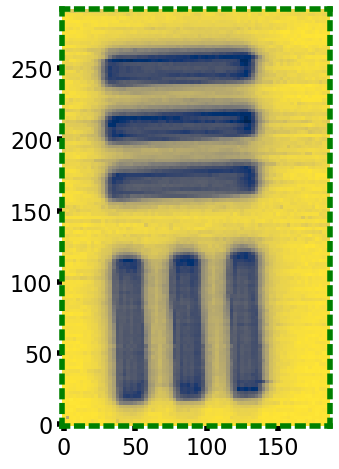

In [8]:
# smallest patterns in group 3
fig, ax = plt.subplots(1, 1)
for i in ['left', 'right', 'top', 'bottom']:
    ax.spines[i].set_linewidth(4)
    ax.spines[i].set_color('g')
    ax.spines[i].set_linestyle('dotted')
ax.tick_params(width=4)
ax.pcolormesh(x_bar - x_bar.min(), y_bar - y_bar.min(), i_bar, cmap=cmap)
cr.square()

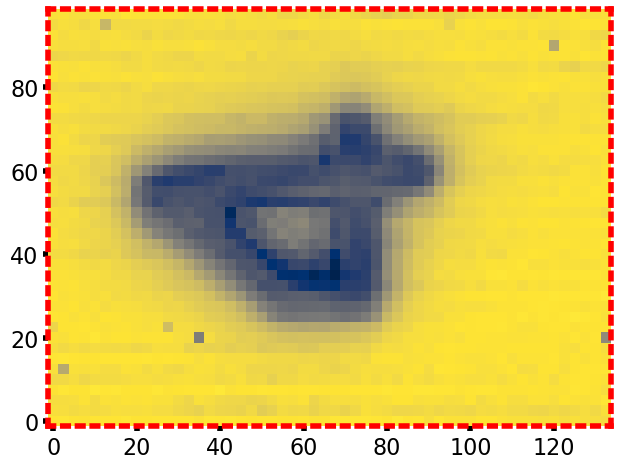

In [9]:
# number 4
fig, ax = plt.subplots(1, 1)
ax.pcolormesh(x_num4 - x_num4.min(), y_num4 - y_num4.min(), i_num4, cmap=cmap)
for i in ['left', 'right', 'top', 'bottom']:
    ax.spines[i].set_linewidth(4)
    ax.spines[i].set_color('r')
    ax.spines[i].set_linestyle('dotted')
ax.tick_params(width=4)
cr.square()


# Calculating SNR Analysis 

##### New Kernel

## Filtering out $f_{ceo}$ and Phase Correction

##### I took free running spectra on SU-8 and off SU-8 to plot the absorbance noise as a function of averaging time, similar to the shocktube experiment

In [1]:
import sys

sys.path.append("../include/")
import numpy as np
import matplotlib.pyplot as plt
import clipboard_and_style_sheet as cr
import td_phase_correct as td
from tqdm import tqdm
import os

In [2]:
cr.style_sheet()

In [3]:
def filt(freq, ll, ul, x, type="bp"):
    if type == "bp":
        return np.where(np.logical_and(freq > ll, freq < ul), x, 0.0)

    elif type == "notch":
        return np.where(np.logical_or(freq < ll, freq > ul), x, 0.0)


In [4]:
path = r"/Volumes/Extreme SSD/Research_Projects/Microscope" \
       r"/FreeRunningSpectra/11-09-2022/"

data = np.load(
    path + "stage1_5116_stage2_8500_53856x74180.npy",
    mmap_mode='r')


In [5]:
ppifg = len(data[0])
center = ppifg // 2
N_IFG = len(data)

data.resize((ppifg * N_IFG,))
data = data[center:-center]
data.resize((N_IFG - 1, ppifg))
rfreq = np.fft.rfftfreq(len(data[0]), 1e-9) * 1e-6  # 0 -> 500 MHz


##### To open 8 consoles, run the cells below with console = 0, 1, 2, 3, 4, 5, 6, 7

In [6]:
step = len(data) // 8
chunks = np.arange(0, len(data), step)
chunks[-1] = len(data)
start = chunks[:-1]
end = chunks[1:]
console = 7


In [ ]:
h = 0
for n in tqdm(range(start[console], end[console])):
    ft = np.fft.rfft(data[n])  # make sure to load from data

    for f in list_filter:
        ft = filt(rfreq, *f, ft, "notch")

    t_filt = np.fft.irfft(ft)
    data_filt[n] = t_filt
    # print(end[console] - start[console] - h - 1) # using tqdm now
    h += 1

In [ ]:
opt = td.Optimize(data_filt[:, center - 50:center + 50])
opt.phase_correct(data_filt,
                  start_index=start[console],
                  end_index=end[console],
                  method='Powell')


## Calculating SNR

##### New Kernel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import clipboard_and_style_sheet as cr
import scipy.signal as si
from tqdm import tqdm
from numpy import ma

In [2]:
cr.style_sheet()

In [3]:
# together
list_filter = np.array([[0, 2],
                        [31, 32.8],
                        [249.5, 250.5],
                        [280, 284],
                        [337, 338],
                        [436, 437],
                        [499, 500]])

In [4]:
def filt(freq, ll, ul, x, type="bp"):
    if type == "bp":
        mask = np.where(np.logical_and(freq > ll, freq < ul), 0, 1)
    elif type == "notch":
        mask = np.where(np.logical_or(freq < ll, freq > ul), 0, 1)

    return ma.array(x, mask=mask)


In [5]:
def apply_filter(ft, lst_fltrs=list_filter):
    rfreq = np.fft.rfftfreq((len(ft) - 1) * 2, 1e-9) * 1e-6
    for f in lst_fltrs:
        ft = filt(rfreq, *f, ft, "notch")

    return ft

In [6]:
def calculate_snr(data, apod=None):
    ppifg = len(data[0])
    center = ppifg // 2

    if not np.any([apod is None, apod == np.nan, ma.is_masked(apod)]):
        # assert isinstance(apod, (int, np.int64)), "apod must be an integer"
        print("apodizing data")
        data = data[:, center - apod // 2:center + apod // 2]
    else:
        print("NOT apodizing data")
    freq = np.fft.rfftfreq(len(data[0]))

    avg = np.mean(data, 0)
    avg -= np.mean(avg)
    ft_avg = np.fft.rfft(avg)

    ll = np.argmin(abs(freq - .10784578053383662))
    ul = np.argmin(abs(freq - .19547047721757888))

    b, a = si.butter(4, .2, "low")
    ft_avg_filt = si.filtfilt(b, a, ft_avg.__abs__())
    denom = ft_avg_filt[ll:ul]

    x = 0
    NOISE = np.zeros(len(data))
    for n, i in enumerate(tqdm(data)):
        i = i - np.mean(i)

        ft = np.fft.rfft(i)
        x = (x * n + apply_filter(ft)) / (n + 1)

        num = x.__abs__()[ll:ul]
        absorption = num / denom
        absorbance = -np.log(absorption)
        noise = np.std(absorbance)
        NOISE[n] = noise

    return NOISE


In [7]:
path = r"/Volumes/Extreme SSD/Research_Projects/Microscope/Python_Workspace" \
       r"/data/phase_corrected/"


In [ ]:
# # data = np.load(  # taken on silicon
# #     path + "stage1_5116_stage2_8500_53856x74180_phase_corrected.npy.npy",
# #     mmap_mode='r')
# data = np.load(  # taken on su8
#     path + "stage1_5300_stage2_8970_53856x74180_phase_corrected.npy",
#     mmap_mode='r')
# ppifg = len(data[0])
# center = ppifg // 2

# resolution = np.arange(0, 500 + 10, 10)
# resolution[0] = 1
# APOD = (1 / resolution) * ppifg
# APOD = np.round(APOD).astype(int)
# APOD = np.where(APOD % 2 == 0, APOD, APOD + 1)

# APOD = ma.asarray(APOD)
# APOD[0] = ma.masked

# SIGMA = np.zeros((len(APOD), len(data)))
# for n, apod in enumerate(APOD):
#     SIGMA[n] = calculate_snr(data, apod)
#     print(f'_____________________{len(APOD) - n - 1}_____________________')

# np.save(path + "su8/sigma/sigma.npy", SIGMA)

# Plotting SNR Analysis

##### New Kernel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import clipboard_and_style_sheet as cr
import scipy.signal as si
from tqdm import tqdm
from numpy import ma
import scipy.constants as sc

In [2]:
cr.style_sheet()

In [3]:
path = r"/Volumes/Extreme SSD/Research_Projects/Microscope/Python_Workspace" \
       r"/data/phase_corrected/"


In [4]:
# together
list_filter = np.array([[0, 2],
                        [31, 32.8],
                        [249.5, 250.5],
                        [280, 284],
                        [337, 338],
                        [436, 437],
                        [499, 500]])

In [5]:
def filt(freq, ll, ul, x, type="bp"):
    if type == "bp":
        mask = np.where(np.logical_and(freq > ll, freq < ul), 0, 1)
    elif type == "notch":
        mask = np.where(np.logical_or(freq < ll, freq > ul), 0, 1)

    return ma.array(x, mask=mask)


In [6]:
def apply_filter(ft, lst_fltrs=list_filter):
    rfreq = np.fft.rfftfreq((len(ft) - 1) * 2, 1e-9) * 1e-6
    for f in lst_fltrs:
        ft = filt(rfreq, *f, ft, "notch")

    return ft

In [7]:
s_su8 = np.load(path + "su8/sigma/sigma.npy")
s_bckgnd = np.load(path + "bckgnd/sigma/sigma.npy")
window = np.load(path + "su8/sigma/NPTS.npy")
ppifg = 74180
center = ppifg // 2

n_ifg = np.arange(1, len(s_bckgnd[0]) + 1)
s_bckgnd_dB = 10 * np.log10(s_bckgnd)
s_su8_dB = 10 * np.log10(s_su8)

snr_bckgnd_dB = 10 * np.log10(1 / s_bckgnd)
snr_su8_dB = 10 * np.log10(1 / s_su8)

resolution = window[0] / window
resolution = np.round(resolution, 0)

In [8]:
# absorbance noise 2D plots
# fig = plt.figure()
# plt.suptitle("background absorbance noise (dB)")
# plt.pcolormesh(n_ifg, resolution, s_bckgnd_dB, cmap='jet')
# plt.xscale('log')
# plt.xlabel("# interferograms")
# plt.ylabel("resolution (GHz)")
# plt.colorbar()
#
# fig = plt.figure()
# plt.suptitle("su8 absorbance noise (dB)")
# plt.pcolormesh(n_ifg, resolution, s_su8_dB, cmap='jet')
# plt.xscale('log')
# plt.xlabel("# interferograms")
# plt.ylabel("resolution (GHz)")
# plt.colorbar()

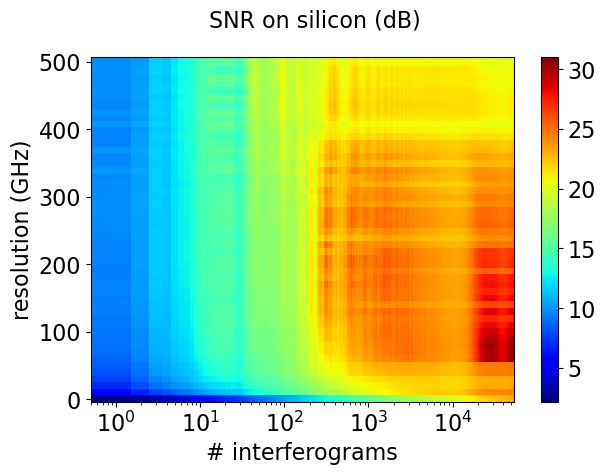

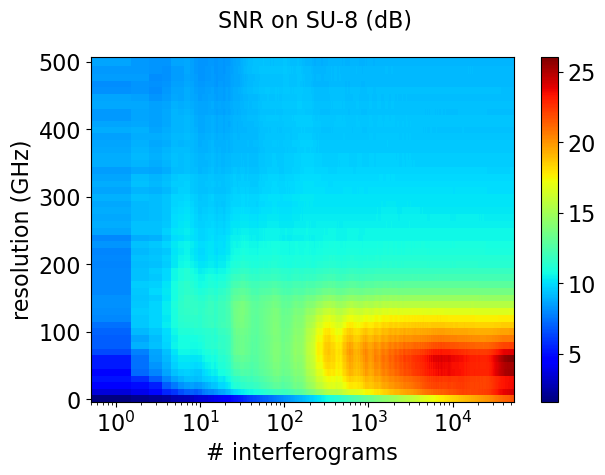

In [9]:
# snr 2D plots
fig = plt.figure()
plt.suptitle("SNR on silicon (dB)")
plt.pcolormesh(n_ifg, resolution, snr_bckgnd_dB, cmap='jet')
plt.xscale('log')
plt.xlabel("# interferograms")
plt.ylabel("resolution (GHz)")
plt.colorbar()

fig = plt.figure()
plt.suptitle("SNR on SU-8 (dB)")
plt.pcolormesh(n_ifg, resolution, snr_su8_dB, cmap='jet')
plt.xscale('log')
plt.xlabel("# interferograms")
plt.ylabel("resolution (GHz)")
plt.colorbar()

Text(0, 0.5, 'SNR (dB)')

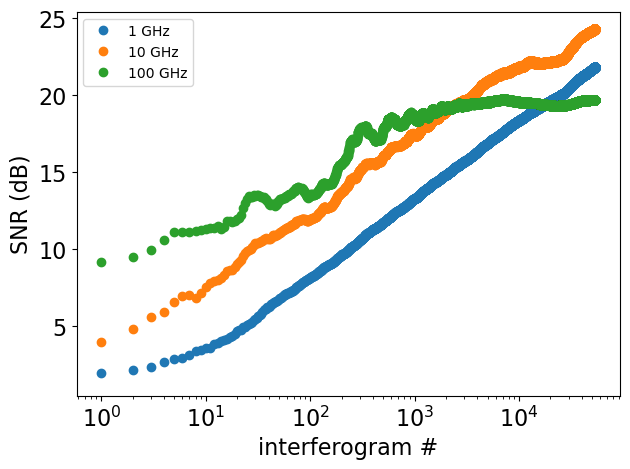

In [10]:
plt.figure()
plt.semilogx(snr_su8_dB[np.argmin(abs(resolution-0))], 'o', label="1 GHz")
plt.semilogx(snr_su8_dB[np.argmin(abs(resolution-10))], 'o', label="10 GHz")
plt.semilogx(snr_su8_dB[np.argmin(abs(resolution-100))], 'o', label="100 GHz")
plt.legend(loc='best')
plt.xlabel("interferogram #")
plt.ylabel("SNR (dB)")

In [11]:
su8 = np.load(path + "stage1_5300_stage2_8970_53856x74180_phase_corrected.npy", mmap_mode='r')
avg_1000 = np.mean(su8[:1000], axis=0)

In [12]:
freq_f = np.fft.rfftfreq(ppifg, 1e-9) * ppifg
freq_f += freq_f[-1] * 2
wl_f = ma.zeros(freq_f.shape)
wl_f[:] = sc.c
wl_f[0] = ma.masked
wl_f[:] /= freq_f

In [13]:
freq_10 = np.fft.rfftfreq(ppifg // 10, 1e-9) * ppifg
freq_10 += freq_10[-1] * 2
wl_10 = ma.zeros(freq_10.shape)
wl_10[:] = sc.c
wl_10[0] = ma.masked
wl_10[:] /= freq_10

In [14]:
freq_100 = np.fft.rfftfreq(ppifg // 100, 1e-9) * ppifg
freq_100 += freq_100[-1] * 2
wl_100 = ma.zeros(freq_100.shape)
wl_100[:] = sc.c
wl_100[0] = ma.masked
wl_100[:] /= freq_100

Text(0.5, 0, 'wavelength ($\\mathrm{\\mu m}$)')

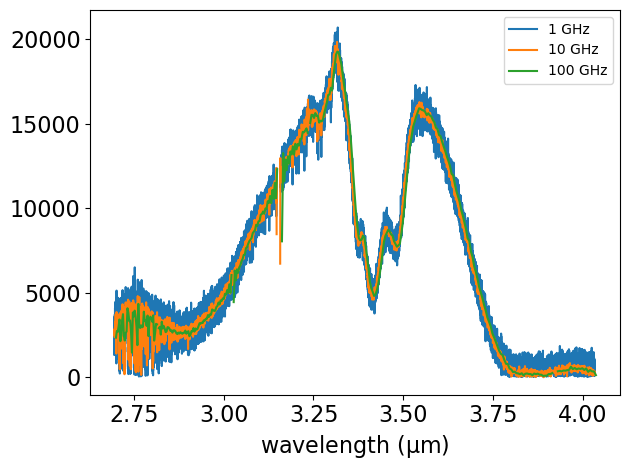

In [15]:
plt.figure()
plt.plot(wl_f * 1e6, apply_filter(abs(np.fft.rfft(avg_1000))), label="1 GHz")
plt.plot(wl_10 * 1e6, 
         apply_filter(abs(np.fft.rfft(avg_1000[center - ppifg // 10 // 2:center + ppifg // 10 // 2]))), 
         label="10 GHz")
plt.plot(wl_100 * 1e6, 
         apply_filter(abs(np.fft.rfft(avg_1000[center - ppifg // 100 // 2:center + ppifg // 100 // 2]))), 
         label="100 GHz")
plt.legend(loc='best')
plt.xlabel("wavelength ($\\mathrm{\\mu m}$)")

In [16]:
# create a gif showing how the absorbance noise changes with
# apodization window
# fig, ax = plt.subplots(1, 2, figsize=np.array([10.64, 4.8]))
# avg = np.load("data/phase_corrected/bckgnd/avg_bckgnd.npy")
# freq_full = np.fft.rfftfreq(len(avg))
# s_full = apply_filter(np.fft.rfft(avg).__abs__())
# ind_full = np.logical_and(freq_full > 0.10784578053383662,
#                           freq_full < 0.19547047721757888).nonzero()[0]
# save = True
# for h, w in enumerate(window):
#     x = avg[center - w // 2:center + w // 2]
#     s = apply_filter(np.fft.rfft(x).__abs__())
#     freq = np.fft.rfftfreq(len(x))
#     ind = np.logical_and(freq > 0.10784578053383662,
#                          freq < 0.19547047721757888).nonzero()[0]

#     [i.clear() for i in ax]
#     ax[0].plot(freq_full[ind_full], s_full[ind_full])
#     ax[0].plot(freq[ind], s[ind])
#     ax[1].loglog(sigma_bckgnd[0], 'o', label="1 GHz")
#     ax[1].loglog(sigma_bckgnd[h], 'o',
#                  label=f'{np.round(74180 / window[h], 1)} GHz')
#     ax[1].set_ylim(
#         0.0005,  # bckgnd
#         # 0.0017, # su8
#         0.8)
#     ax[1].legend(loc='best')
#     if save:
#         plt.savefig(f'fig/{h}.png')
#     else:
#         plt.pause(.05)

#     print(len(window) - h - 1)
